In [1]:
# Removed triangles and coeffcient
# Changed proportion of negative links used
# Added surname community detection features
# Same as Version three except using connectionID instead of nodeID (which changes)
# Added community detection features - label prop and louvain
# Added triangles and clustering coefficient

In [2]:
from py2neo import Graph
import pandas as pd

import matplotlib 
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import pandas as pd
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
graph = Graph("bolt://localhost", auth=("neo4j", "123"))
import pickle

In [3]:
def down_sample(df):
    dscopy = df.copy()
    
    negatives = Counter(dscopy.label.values)[0]
    positives = Counter(dscopy.label.values)[1]
    
    # Use a smaller subset of negative values
    samplesize = round(negatives - (positives))
                       
    dscopy = dscopy.drop(dscopy[dscopy.label == 0].sample(n=samplesize, random_state=1).index)
    return dscopy.sample(frac=1)

def evaluate_model(predictions, actual):
    return pd.DataFrame({
        "Measure": ["Accuracy", "Precision", "Recall"],
        "Score": [accuracy_score(actual, predictions), 
                  precision_score(actual, predictions), 
                  recall_score(actual, predictions)]
    })

def feature_importance(columns, classifier):        
    display("Feature Importance")
    df = pd.DataFrame({
        "Feature": columns,
        "Importance": classifier.feature_importances_
    })
    df = df.sort_values("Importance", ascending=False)    
    ax = df.plot(kind='bar', x='Feature', y='Importance', legend=None)
    ax.xaxis.set_label_text("")
    plt.tight_layout()
    plt.show()

In [4]:
def create_LP_features(data, rel_type):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1:Person) 
    USING INDEX p1:Person(connectionid) 
    WHERE p1.connectionid = pair.node1
    MATCH (p2:Person) 
    USING INDEX p2:Person(connectionid) 
    WHERE p2.connectionid = pair.node2
    RETURN pair.node1 AS node1,
           pair.node2 AS node2,
           algo.linkprediction.commonNeighbors(
               p1, p2, {relationshipQuery: $relType}) AS cn,
           algo.linkprediction.adamicAdar(
               p1, p2, {relationshipQuery: $relType}) AS aa,
           algo.linkprediction.preferentialAttachment(
               p1, p2, {relationshipQuery: $relType}) AS pa,
           algo.linkprediction.totalNeighbors(
               p1, p2, {relationshipQuery: $relType}) AS tn,
           algo.linkprediction.resourceAllocation(
               p1, p2, {relationshipQuery: $relType}) AS ra
               
    """
    pairs = [{"node1": node1, "node2": node2}  for node1,node2 in data[["node1", "node2"]].values.tolist()]
    features = graph.run(query, {"pairs": pairs, "relType": rel_type}).to_data_frame()
    features = features.drop_duplicates()
    return pd.merge(data, features, on = ["node1", "node2"])


def communitydetection_features(data, partition_prop, louvain_prop):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1:Person) 
    USING INDEX p1:Person(connectionid) 
    WHERE p1.connectionid = pair.node1
    MATCH (p2:Person) 
    USING INDEX p2:Person(connectionid) 
    WHERE p2.connectionid = pair.node2
    RETURN pair.node1 AS node1,
    pair.node2 AS node2,
    algo.linkprediction.sameCommunity(p1, p2, $partitionProp) AS lp,    
    algo.linkprediction.sameCommunity(p1, p2, $louvainProp) AS lv
    """
    pairs = [{"node1": node1, "node2": node2}  for node1,node2 in data[["node1", "node2"]].values.tolist()]
    params = {
    "pairs": pairs,
    "partitionProp": partition_prop,
    "louvainProp": louvain_prop
    }
    features = graph.run(query, params).to_data_frame()
    features = features.drop_duplicates()
    return pd.merge(data, features, on = ["node1", "node2"])

def samename_features(data, samename_prop):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1:Person) 
    USING INDEX p1:Person(connectionid) 
    WHERE p1.connectionid = pair.node1
    MATCH (p2:Person) 
    USING INDEX p2:Person(connectionid) 
    WHERE p2.connectionid = pair.node2
    RETURN pair.node1 AS node1,
    pair.node2 AS node2,
    algo.linkprediction.sameCommunity(p1, p2, $samenameProp) AS sn
"""
    pairs = [{"node1": node1, "node2": node2}  for node1,node2 in data[["node1", "node2"]].values.tolist()]
    params = {
    "pairs": pairs,
    "samenameProp": samename_prop
    }
    features = graph.run(query, params).to_data_frame()
    features = features.drop_duplicates()
    return pd.merge(data, features, on = ["node1", "node2"])


In [5]:
# Create the classifier
        
#rfclassifier = RandomForestClassifier(n_estimators=500, max_depth=50, 
                                  # random_state=0,class_weight="balanced")

rfclassifier = ExtraTreesClassifier(n_estimators=1000, max_depth=50, 
                                  random_state=0,class_weight="balanced")

# Feature column names for a full set of features
#columns = [
#    "cn","aa", "pa", "tn","ra", # graph features
#    "minTriangles", "maxTriangles", "minCoefficient", "maxCoefficient", # triangle features  
#    "sp", "sl" # community detection features
#]

# Feature column names for a full link prediction features
columns = ["cn","aa","pa", "tn","ra", # link prediction features
        "sn"                              # same name feature 
]

In [6]:
# TRAINING
# Find positive links -Training data
train_positive_links = graph.run("""
MATCH (p1:Person)-[:SUB_GRAPH_TRAINING]->(p2:Person)
RETURN p1.connectionid AS node1, p2.connectionid AS node2, 1 AS label
""").to_data_frame()

In [7]:
# TEST
# Find positive links - Test data
test_positive_links = graph.run("""
MATCH (p1:Person)-[:SUB_GRAPH_TEST]->(p2:Person)
RETURN p1.connectionid AS node1, p2.connectionid AS node2, 1 AS label
""").to_data_frame()

In [8]:
# TRAINING
# Find negative links - Training data
train_negative_links = graph.run("""
MATCH (p1:Person)
WHERE (p1)-[:SUB_GRAPH_TRAINING]-()
MATCH (p1)-[:SUB_GRAPH_TRAINING*2..3]-(p2)
WHERE not((p1)-[:SUB_GRAPH_TRAINING]-(p2))
RETURN p1.connectionid AS node1, p2.connectionid AS node2, 0 AS label
""").to_data_frame()

In [9]:
# TEST
# Find negative examples - test set
test_negative_links = graph.run("""
MATCH (p1:Person)
WHERE (p1)-[:SUB_GRAPH_TEST]-()
MATCH (p1)-[:SUB_GRAPH_TEST*2..3]-(p2)
WHERE not((p1)-[:SUB_GRAPH_TEST]-(p2))
RETURN p1.connectionid AS node1, p2.connectionid AS node2, 0 AS label
""").to_data_frame()

In [10]:
# TRAINING
# Remove duplicates - training set
train_negative_links = train_negative_links.drop_duplicates()

#Down sample Negative links
training_df = train_negative_links.append(train_positive_links, ignore_index=True)
training_df['label'] = training_df['label'].astype('category')
training_df = down_sample(training_df)

In [11]:
# TEST
# Remove duplicates - test set
test_negative_links = test_negative_links.drop_duplicates()

# Create DataFrame from positive and negative examples
test_df = test_negative_links.append(test_positive_links, ignore_index=True)
test_df['label'] = test_df['label'].astype('category')
# Down sample negative examples
test_df = down_sample(test_df)

In [12]:
# TRAINING
# Apply the link prediction features to the data set
training_df = create_LP_features(training_df, "SUB_GRAPH_TRAINING")

In [13]:
# TEST
# Apply the link prediction features to the data set
test_df = create_LP_features(test_df, "SUB_GRAPH_TEST")

In [14]:
training_df = samename_features(training_df, "surnameID")
#TEST
test_df = samename_features(test_df, "surnameID")

In [15]:
training_df.tail()

,node1,node2,label,cn,aa,pa,tn,ra,sn
163783,25812,26446,1,7.000,3.801,64.000,9.000,1.105,1.000
163784,50807,5590,1,0.000,0.000,2.000,3.000,0.000,0.000
163785,76172,19373,0,0.000,0.000,128.000,24.000,0.000,0.000
163786,78415,80640,1,2.000,1.822,39.000,14.000,0.571,0.000
163787,76717,77363,1,6.000,5.516,49.000,8.000,1.950,1.000


,Measure,Score
0,Accuracy,0.893
1,Precision,0.871
2,Recall,0.922


'Feature Importance'

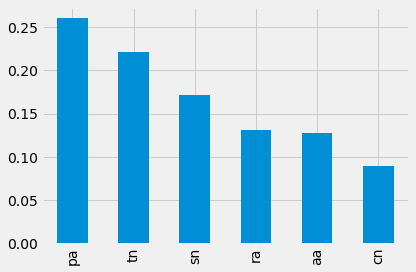

In [16]:
# Run the classifier against the training data
X = training_df[columns]
y = training_df["label"]
rfclassifier.fit(X, y)

# Apply the test data and evaluate performance
predictions = rfclassifier.predict(test_df[columns])
y_test = test_df["label"]

display(evaluate_model(predictions, y_test))
feature_importance(columns, rfclassifier)

In [17]:
filename = 'd:\projectdata\models\CDMLWU_v6.sav'
pickle.dump(rfclassifier, open(filename, 'wb'))